In [1]:
import pandas as pd
import numpy as np
import bentoml
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance

import xgboost as xgb

/Users/jainendra/.local/share/virtualenvs/week-7-Lz0kreyU/lib/python3.10/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df=pd.read_csv("data.csv")

In [3]:
df.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [4]:
#check null values
df.isna().sum()

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

### Univariate EDA

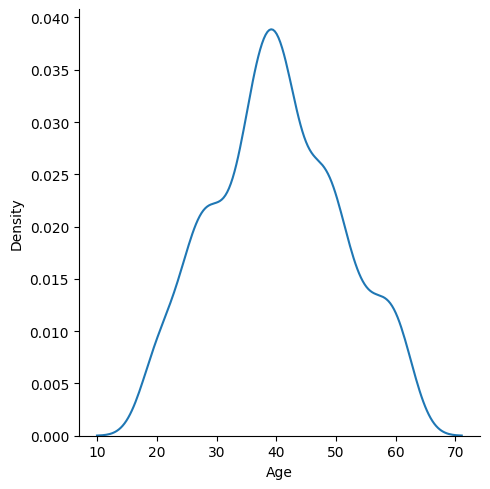

In [5]:
sns.displot(df, x="Age", kind="kde")

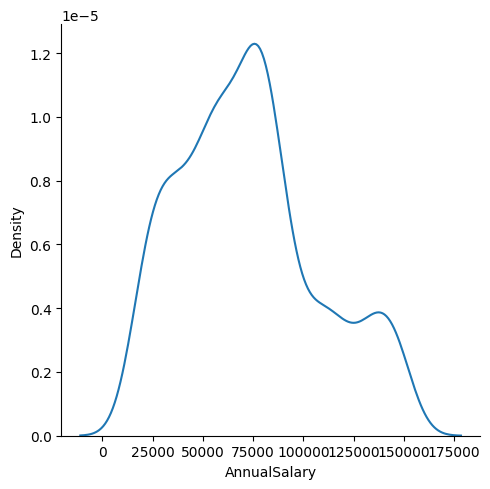

In [6]:
sns.displot(df, x="AnnualSalary", kind="kde")

### Bivariate EDA

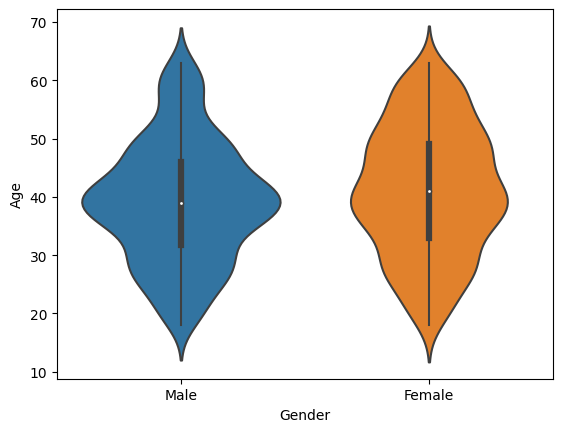

In [7]:
ax = sns.violinplot(x="Gender", y="Age", data=df)

/var/folders/9w/y7n1cknx6b129gych5c5_zxc0000gn/T/ipykernel_48491/1145513917.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = project_data.corr()


<AxesSubplot: >

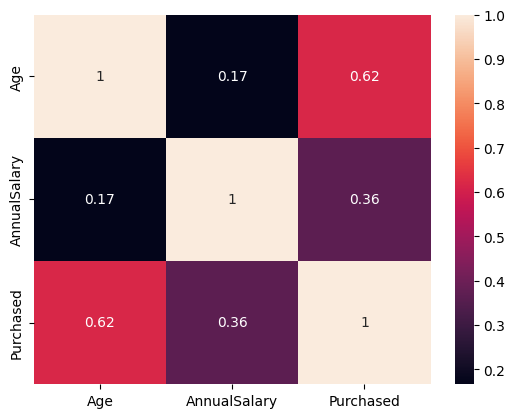

In [8]:
project_data = df.drop(columns=['User ID'], axis=1)
corr = project_data.corr()
sns.heatmap(corr, annot=True)

### feature engineering

In [9]:


df["Gender"]=df["Gender"].apply(lambda x: 1 if x=="Male" else 0)

In [10]:
df.columns

Index(['User ID', 'Gender', 'Age', 'AnnualSalary', 'Purchased'], dtype='object')

### Feature importance analysis

In [11]:
X = pd.DataFrame(df, columns=['User ID','Gender', 'Age', 'AnnualSalary'])
y = df.Purchased
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150)

Text(0.5, 0, 'Feature Importance')

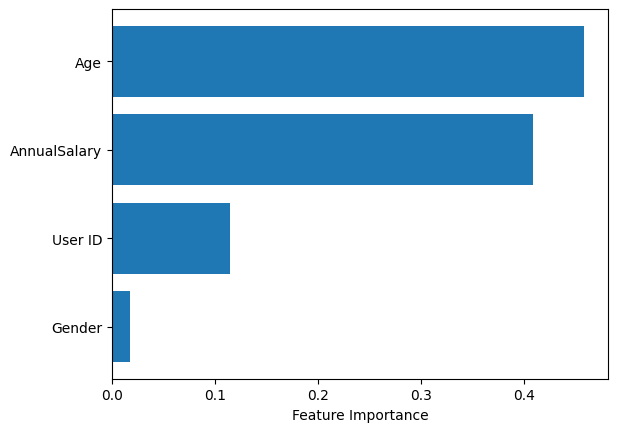

In [13]:
sort = rf.feature_importances_.argsort()
plt.barh(df.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

#### 1. Decision trees training

In [14]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        
        scores.append((depth, s, auc))

In [15]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [16]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.962  0.961  0.945
5                 0.962  0.965  0.959
10                0.959  0.964  0.962
15                0.958  0.955  0.960
20                0.960  0.962  0.963
100               0.928  0.928  0.928
200               0.889  0.889  0.889
500               0.500  0.500  0.500

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

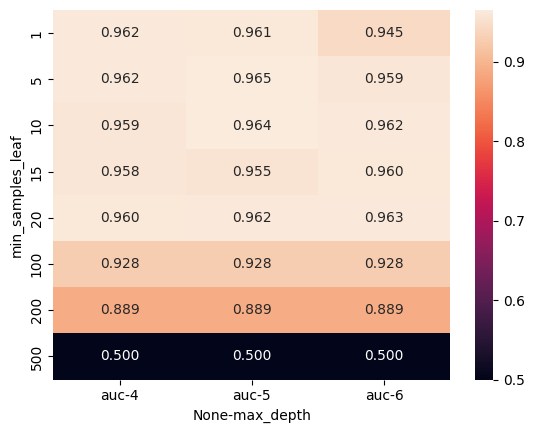

In [17]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [18]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

### 2. Random forest training


In [19]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)

        scores.append((d, n, auc))

In [20]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

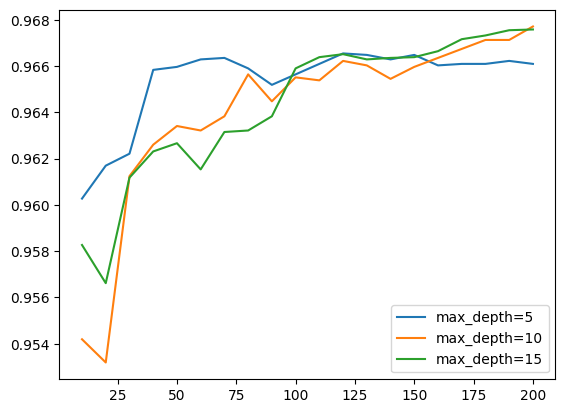

In [21]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [22]:
max_depth = 15

In [23]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)

        scores.append((s, n, auc))

In [24]:

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

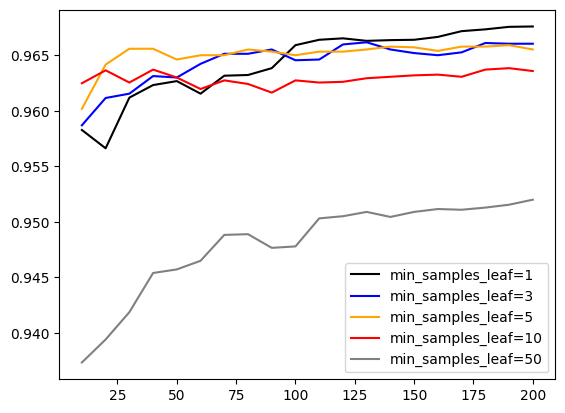

In [25]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [26]:
min_samples_leaf = 1

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=1)

### 3. XGboost
Decision trees parameter tuning

In [27]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/Users/jainendra/.local/share/virtualenvs/week-7-Lz0kreyU/lib/python3.10/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [28]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [29]:
y_pred = model.predict(dtest)
print("roc_auc_score:",roc_auc_score(y_test, y_pred))

#print(confusion_matrix(y_test, y_pred))

roc_auc_score: 0.9672619047619048


In [30]:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

In [31]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [32]:
s = output.stdout
print(s[:200])

[0]	train-auc:0.96589	test-auc:0.94122
[5]	train-auc:0.99109	test-auc:0.96561
[10]	train-auc:0.99494	test-auc:0.96878
[15]	train-auc:0.99746	test-auc:0.97166
[20]	train-auc:0.99854	test-auc:0.96856
[2


In [33]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'test_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [34]:
df_score = parse_xgb_output(output)

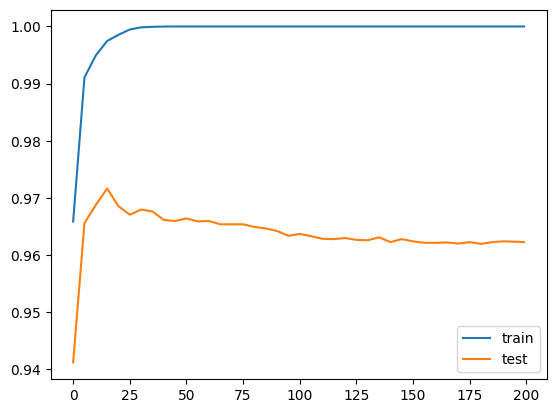

In [35]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.test_auc, label='test')
plt.legend()

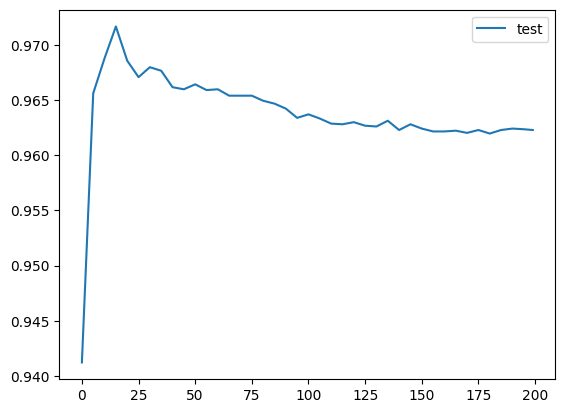

In [36]:
plt.plot(df_score.num_iter, df_score.test_auc, label='test')
plt.legend()

### XGBoost parameter tuning
##### Tuning the following parameters:

##### eta
##### max_depth

In [37]:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[16:54:27] WARNING: /Users/jainendra/Documents/mlzoomcamp2k22/week-7/xgboost-1.4.2/build/temp.macosx-10.9-universal2-cpython-310/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
scores = {}

In [39]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [40]:
scores = {}

In [41]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [42]:
#scores

In [43]:
scores = {}

In [44]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [45]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

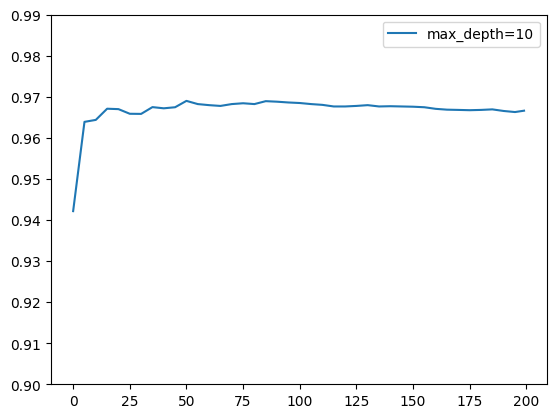

In [46]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.test_auc, label=max_depth)

plt.ylim(0.9, 0.99)
plt.legend()

### Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [47]:
## Decisiontree
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9596920289855073

In [48]:
## randomforest
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.965515010351967

In [49]:
## XGBoost
xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=50)
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.9691381987577641

### ROC AUC Score of following algorithm 
 Decisiontree |Randomforest | XGBoost
| :--- | ---: | :---:
 0.9596  | 0.9655 | 0.9691

 Conclusion : I am going to select Randomforest as final model because random forest and XgBoost giving nearly same accuracy and random forest model are lite weight compaired to XGBoost. 

In [50]:
import json
request = df.iloc[0].to_dict()
print(json.dumps(request, indent=2))

{
  "User ID": 385,
  "Gender": 1,
  "Age": 35,
  "AnnualSalary": 20000,
  "Purchased": 0
}


In [51]:
df.dtypes

User ID         int64
Gender          int64
Age             int64
AnnualSalary    int64
Purchased       int64
dtype: object

In [ ]:
Users/jainendra/bentoml/models